# 1. Method 1

1. Bootstrap sample two samples from null population, and assign as `candidate` and `noncandidate`. Repeat 1000 times. 

>`whole_sample = candidate.append(noncandidate)`

>`mock_candidate = bs(whole_sample)`

>`mock_noncandidate = bs(whole_sample)`

2. Calculate null population mean and standard deviation of `mock_candidate - mock_candidate`
3. Calculate sample mean from the original candidate/noncandidate pool of dfe_alpha output values.
4. Calculate p-value.

>`p-value = number of (mean(bs(mock_candidate))-mean(bs(mock_noncandidate)) / number of bootstrap runs`


In [243]:
import pandas as pd
from sklearn.utils import resample
import random
import matplotlib.pyplot as plt
from scipy import stats
import math

In [244]:
df = pd.read_csv("../../data/dfe_alpha_analysis/20210204_composite_genome/bootstrap_values.txt", sep='\t')
df.columns = ["group","alpha", "omega","pFDM", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"]
df = df.drop(columns=["pFDM"])

In [245]:
df.head()

,group,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
0,noncandidate,0.264506,0.085500,0.252094,0.061857,0.077035,0.609015
1,candidate,0.486018,0.145958,0.166344,0.055530,0.074067,0.704058
2,noncandidate,0.203251,0.064773,0.266185,0.050104,0.059535,0.624176
3,candidate,0.438839,0.130599,0.177601,0.046088,0.058048,0.718262
4,noncandidate,0.354435,0.116164,0.226874,0.070282,0.092047,0.610797


In [246]:
# construct the simulated null population distribution
population= pd.DataFrame(columns = ["alpha", "omega", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"])

for i in range(1000):
    random.seed(i)
    
    #Resample to create mock candidate and noncandidates form null population
    mock_candidate = resample(df, replace=True, n_samples=100, random_state=random.randint(0,10000))
    mock_noncandidate = resample(df, replace=True, n_samples=100, random_state=random.randint(0,10000))
    
    #Calculate mean and standard deviation of candidate-noncandidate
    mean_c = mock_candidate.agg(['mean'])
    mean_nc = mock_noncandidate.agg(['mean'])
    var_c = mock_candidate.agg(['std']).apply(lambda x: x**2)
    var_nc = mock_noncandidate.agg(['std']).apply(lambda x: x**2)
    output_std = pd.Series((var_c+var_nc).apply(lambda x: math.sqrt(x)), name = 'std')
    output = mean_c-mean_nc
    
    #Add mean and std to a running dataframe 
    population = population.append(output.append(output_std))

In [247]:
population.head()

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
mean,0.000639,-0.000299,-0.001638,-0.002117,-0.003044,0.006799
std,0.096500,0.026402,0.038932,0.015926,0.024484,0.051046
mean,0.000572,0.000422,0.000924,0.001989,0.003074,-0.005987
std,0.096073,0.025473,0.039858,0.018031,0.029526,0.055694
mean,-0.007309,-0.002233,0.002370,-0.001146,-0.002191,0.000967


In [248]:
# the simulated mean and standard deviation of the null population distribution (estimated with bootstrapping)
population_summary = population[population.index == 'mean'].agg(['mean'])
population_summary = population_summary.append(population[population.index == 'std'].agg(['mean']))
population_summary = population_summary.reset_index()
population_summary.index = ['mean', 'std']

In [249]:
population_summary

,index,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
mean,mean,-0.000219,-0.000025,0.000145,-0.000015,-0.000038,-0.000091
std,mean,0.096481,0.025953,0.039419,0.017660,0.028653,0.053440


In [250]:
# the mean and standard deviation of the sample distribution
c_summary = df[df.group == 'candidate'].agg(['mean','std'])
nc_summary = df[df.group == 'noncandidate'].agg(['mean','std'])
df_summary = c_summary - nc_summary
std_tmp = c_summary[c_summary.index == 'std'].apply(lambda x: x**2) + nc_summary[nc_summary.index == 'std'].apply(lambda x: x**2)
std_tmp = pd.Series(std_tmp.apply(lambda x: math.sqrt(x)), name = 'std')
df_summary = df_summary.drop(index = 'std').append(std_tmp)

In [251]:
df_summary

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
mean,0.101022,0.021351,-0.050461,0.002053,0.007490,0.040918
std,0.065176,0.021203,0.016843,0.017703,0.028365,0.045219


#### Calculate p-value
z = (mean of sample - mean of population)/(population std/sqrt(sample_n))

In [252]:
#how often is bs_diff greater than candidate(value)-noncandidate(value)?
sample_stats = pd.DataFrame(columns = ["alpha", "omega", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"], 
                            index = ['pop>sample', 'pop<sample','p_value'])
for col in sample_stats.columns:
    greater = sum([1 for i in population.loc['mean',col] if i > df_summary.loc['mean',col]])
    sample_stats.loc['pop>sample',col] = greater
    less = sum([1 for i in population.loc['mean',col] if i < df_summary.loc['mean',col]])
    sample_stats.loc['pop<sample',col] = less
    sample_stats.loc['p_value',col]= greater/sum([greater, less])

In [255]:
sample_stats

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
pop>sample,0,0,1000,127,2,0
pop<sample,1000,1000,0,873,998,1000
p_value,0,0,1,0.127,0.002,0


population mean = -0.00022
population sd = 0.09648
sample mean = 0.10102
boostrap p-value = 0.0



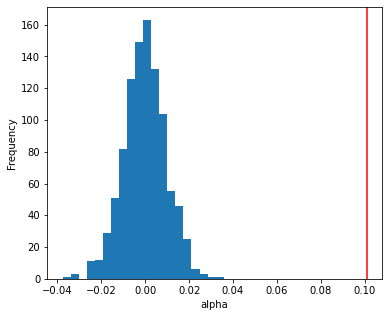

population mean = -2e-05
population sd = 0.02595
sample mean = 0.02135
boostrap p-value = 0.0



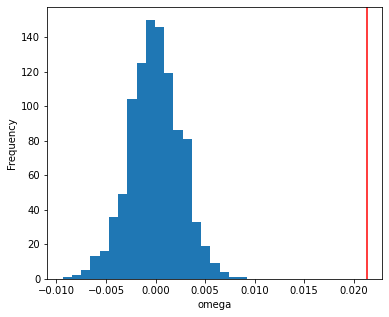

population mean = 0.00014
population sd = 0.03942
sample mean = -0.05046
boostrap p-value = 1.0



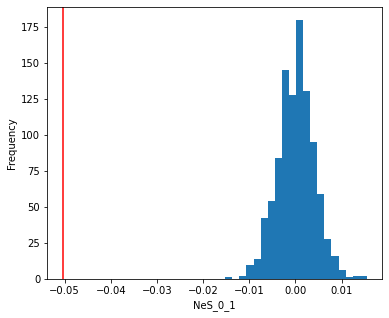

population mean = -2e-05
population sd = 0.01766
sample mean = 0.00205
boostrap p-value = 0.127



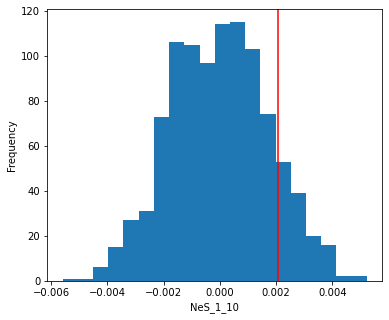

population mean = -4e-05
population sd = 0.02865
sample mean = 0.00749
boostrap p-value = 0.002



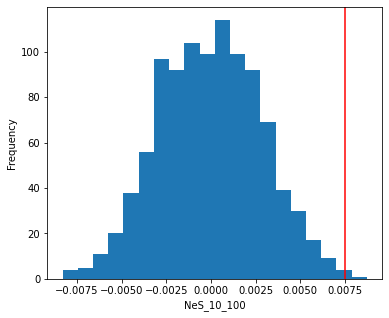

population mean = -9e-05
population sd = 0.05344
sample mean = 0.04092
boostrap p-value = 0.0



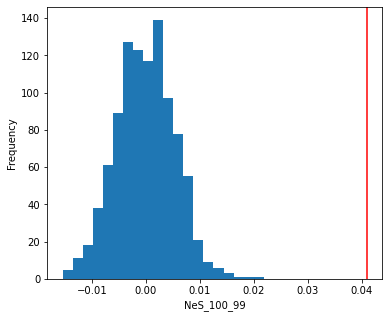

In [254]:

for col in sample.columns:
    
    #annotation
    #'z-score p-value = {}\n'.format(round(p_value[col],5)) + \
    text_string = "population mean = {}\n".format(round(population_summary.loc['mean',col], 5))+ \
                    "population sd = {}\n".format(round(population_summary.loc['std',col], 5))+ \
                    "sample mean = {}\n".format(round(df_summary.loc['mean',col],5)) + \
                    'boostrap p-value = {}\n'.format(round(sample_stats.loc['p_value',col],5))
    #confidence_int = "95% confidence interval: (" + str(round(sample_summary.loc['mean',col] - 2*sample_summary.loc['std',col], 5)) + ", " + \
    #                str(round(sample_summary.loc['mean',col] + 2*sample_summary.loc['std',col], 5)) +")"
    print(text_string)
    
    plt.figure(figsize=(6, 5))
    population[population.index == 'mean'][col].plot(kind = "hist", density = False, bins = 20)
    #sample_diff[col].plot(kind = "kde")
    #plt.ylabel('Counts')
    plt.xlabel(col)
    
    #ax.set_ylim(0, 1)

    plt.axvline(x = df_summary.loc['mean',col], color = 'red', \
                label='sample mean\nx = {}'.format(df_summary.loc['mean',col]))
    plt.show()
    #plt.grid(None) 